In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function
from scipy.io import loadmat
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from handcrafted_descriptors.grid_classification import kernels as krn
#from handcrafted_descriptors.grid_classification import accuracy_and_test as aat
from handcrafted_descriptors.grid_classification import utils
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import pickle
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV

In [3]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


In [4]:
def train_model_and_calculate_accuracy(train_features,train_lab,test_features,test_lab): 
    scaler = StandardScaler()
    scaler.fit(train_features)

    #X_train = scaler.transform(train_features)
    X_train = train_features
    #X_test = scaler.transform(test_features)
    X_test = test_features
    
    clc = []
    acc = []
    prec = []
    rec = []
    for i in range(1,51):
        classifier = KNeighborsClassifier(n_neighbors=i) 
        classifier.fit(X_train, train_lab)
        clc.append(classifier)
        y_pred = classifier.predict(X_test)
        acc_temp = 0
        total = y_pred.shape[0]
        for j in range(y_pred.shape[0]):
            if y_pred[j]==test_lab[j]:
                acc_temp = acc_temp + 1
        precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, y_pred)
        prec.append(np.mean(precision))
        rec.append(np.mean(recall))
        acc.append(acc_temp/total)
    return acc, prec, rec,clc 

In [5]:
def load_descriptor_from_matfile(ft_path,lab_path):
    feat = loadmat(ft_path)
    feat = feat['features']
    lab = loadmat(lab_path)
    lab = lab['labels']
    return feat, lab


def define_and_train_svm(tr_feature, tr_lab, kernel_type, distance = None):
    if distance == None:
        print('here')
        svc  = OneVsRestClassifier(SVC(kernel = kernel_type,gamma = 'scale'),n_jobs = -1)
        svc = svc.fit(tr_feature, tr_lab)
        return svc, 0, np.zeros(tr_feature.shape[0])
    else:
        gram= krn.compute_gram_matrix(tr_feature,distance)
        mean = np.mean(gram[np.triu_indices(np.shape(tr_feature)[0])])
        gram = np.exp(-(gram/mean)) # generalized Gaussian kernel
        svc  = OneVsRestClassifier(SVC(kernel = 'precomputed'),n_jobs = -1)
        svc = svc.fit(gram,np.array(tr_lab))
        return svc, mean,gram



def equal(a,b):
    for i in range(a.shape[0]):
        if a[i]!=b[i]:
            return False
    return True





def test_accuracy(test_features,features,kernel,mean, test_label,svc):
    num_objects = features.shape[0]
    res = []
    prediction = []
    for i,ft in enumerate(test_features):
        if(i%200 ==0):
            print(i)

        pred = svc.predict(np.array([kernel(ft, features[num, :], mean) for num in range(num_objects)]).reshape(1, -1))
        prediction.append(pred[0])
        #print(i,": ",pred," : ",test_label[i])
        if(pred==test_label[i]):
            res.append(1)
        else:
            res.append(0)

    res = np.array(res).reshape(-1)
    return np.sum(res)/res.shape, np.array(prediction)


def calculate_and_plot_precision_recall(tst_lab, pred, species, directory, string):
    precision, recall, fbeta, support = precision_recall_fscore_support(tst_lab, pred)
    
    df = pd.DataFrame({"X":species, "precision":precision,"recall":recall,'f1score': fbeta})
    df.plot(x="X", y=["precision", "recall",'f1score'], kind="bar")
    plt.tight_layout()
    plt.savefig(directory +'precision_recall_class4class'+string+'.jpg')
    return np.mean(precision), np.mean(recall), np.mean(fbeta)



In [6]:
def search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'C': [ 1e0, 1e1, 1e2,1e3], 'gamma': [   0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0,skmetrics.accuracy_score(y_pred, tst_lab)

def search_for_best_poly(training_feat, tr_lab, tst_features, tst_lab):
    param_grid = {'degree':[2,3,4,5,6,7],'C': [1e-3,1e-2, 1e-1, 1e0, 1e1, 1e2,1e3], 'gamma': [  0.00001,0.0001,0.001, 0.01, 0.1,1]}
    clf0 = GridSearchCV(SVC(kernel='degree'), param_grid)
    svc = clf0.fit(training_feat, tr_lab)
    print("Best estimator found by grid search : ", clf0.best_estimator_)
    y_pred = clf0.predict(tst_features)
    print('Accuracy score :', skmetrics.accuracy_score(y_pred, tst_lab))
    return clf0, skmetrics.accuracy_score(y_pred, tst_lab)

def create_and_save_confusion_matrix(model, tst_features, tst_lab, species, vw,director, name ):
    pred = model.predict(tst_features)
    df = utils.evaluated_prediction(pred, tst_lab, species)
    cm = utils.build_confusion_matrix(df, pred, tst_lab,species)
    fig=plt.figure(figsize=(30, 15))
    utils.plot_confusion_matrix(cm,species,name,director,normalize=True,title='Confusion matrix')
    plt.close()
    return pred

import matplotlib.pyplot as plt
def plot_and_save_knn(acc,prec,rec,direct):
    x1 = np.arange(1,51)
    plt.plot(x1, acc, label = "accuracy",color = 'r')
    plt.plot(x1,prec, label = 'precision')
    plt.plot(x1, rec, label = 'recall',color = 'g')
    plt.xlabel('number of neighbors')
    plt.ylabel('percentage (%)')
    plt.legend()
    plt.grid()
    plt.savefig(direct)
    plt.close()

accuracy = []
precision = []
recall = []
f1score = []

In [7]:
os.listdir('../../../scale_prop')

FileNotFoundError: [Errno 2] No such file or directory: '../../../scale_prop'

In [ ]:
visual = '500'
precision = []
recall = []
accuracy = []
gridsize = ['4','6','8','12','16','24']


for i,gr in enumerate(gridsize):
    print('------> ',gr)
    trf = '../../../rgb_feat/rgb_' + gr +'_' + visual + '_rbf/training_features.mat'
    trlab = '../../../rgb_feat/rgb_' + gr +'_' + visual + '_rbf/training_lab_features.mat'

    tstf = '../../../rgb_feat/rgb_' + gr +'_' + visual + '_rbf/testing_features.mat'
    tstlab = '../../../rgb_feat/rgb_' + gr +'_' + visual + '_rbf/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1

    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    accuracy.append(score)
    name = "rbg_8_"+gr+'opponent_'
    direc = ""
    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, gr,direc,name)
    
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'prova' + gr +'_')
    precision.append(a)
    recall.append(b)

In [ ]:
df = pd.DataFrame({"X":gridsize, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('density of the grid (in pixel)')
plt.ylabel('Percentate %')
plt.tight_layout()
plt.savefig('results/grid_results/phow_500/total/acc_prec_rec.jpg')

# classic sift

In [ ]:

precision = []
recall = []
accuracy = []
visual = ['200','250','300','350','400','450','500','550','600','650','700','750','800','850','900']


for i,vs in enumerate(visual):
    print('------> ',vs)
    trf = '../../../features_for_python/classic_sift_' + vs +'/training_features.mat'
    trlab = '../../../features_for_python/classic_sift_' + vs +'/training_lab_features.mat'

    tstf = '../../../features_for_python/classic_sift_' + vs + '/testing_features.mat'
    tstlab = '../../../features_for_python/classic_sift_' + vs + '/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1

    #knnacc, knnprec, knnrec ,_ = train_model_and_calculate_accuracy(training_feat,tr_lab,tst_features,tst_lab)
    
    
    #classifier = KNeighborsClassifier(n_neighbors=1) 
    #classifier.fit(training_feat,tr_lab)
    name = "classic_sift"+str(vs)
    direc = "results/classic_sift/confusion_matrix/"
    #pred = create_and_save_confusion_matrix(classifier, tst_features, tst_lab, species, vs,'','knn_' + vs + '.jpg')
    
    
    
    #plot_and_save_knn(knnacc, knnprec, knnrec,'classic_sift_knn_' + vs + '.jpg')
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    accuracy.append(score)

    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, vs,direc,name)
    
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'prova' + vs +'_')
    precision.append(a)
    recall.append(b)

In [ ]:
df = pd.DataFrame({"X":visual, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('number of visualwords')
plt.ylabel('Percentate %')
plt.tight_layout()

# SPECIFIC CLASSIC SIFT MODEL

In [ ]:
vs = '650'
trf = '../../../features_for_python/classic_sift_' + vs +'/training_features.mat'
trlab = '../../../features_for_python/classic_sift_' + vs +'/training_lab_features.mat'

tstf = '../../../features_for_python/classic_sift_' + vs + '/testing_features.mat'
tstlab = '../../../features_for_python/classic_sift_' + vs + '/testing_lab_features.mat'

training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

tr_lab = tr_lab -1
tst_lab = tst_lab -1

svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
accuracy.append(score)
name = "classic_sift"
direc = ""
pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, vs,direc,name)
a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'pca_classic_sift' + vs +'_')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
knnacc, knnprec, knnrec ,_ = train_model_and_calculate_accuracy(training_feat,tr_lab,tst_features,tst_lab)
    


In [ ]:
import matplotlib.pyplot as plt
x1 = np.arange(1,51)
plt.plot(x1, knnacc, label = "accuracy",color = 'r')
plt.plot(x1,knnprec, label = 'precision')
plt.plot(x1, knnrec, label = 'recall',color = 'g')
plt.xlabel('number of neighbors')
plt.ylabel('percentage (%)')
plt.legend()
plt.grid()
#plt.savefig('results/grid_results/k-nearest_neighbor_total.jpg')

In [ ]:

precision = []
recall = []
accuracy = []
visual = ['200','250','300','350','400','450','500','550','600','650','700','750','800','850','900']


for i,vs in enumerate(visual):
    print('------> ',vs)
    trf = '../../../features_for_python/classic_sift_' + vs +'/training_features.mat'
    trlab = '../../../features_for_python/classic_sift_' + vs +'/training_lab_features.mat'

    tstf = '../../../features_for_python/classic_sift_' + vs + '/testing_features.mat'
    tstlab = '../../../features_for_python/classic_sift_' + vs + '/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1

    knnacc, knnprec, knnrec ,_ = train_model_and_calculate_accuracy(training_feat,tr_lab,tst_features,tst_lab)
    
    classifier = KNeighborsClassifier(n_neighbors=1) 
    classifier.fit(training_feat,tr_lab)
    pred = create_and_save_confusion_matrix(classifier, tst_features, tst_lab, species, vs,'','knn_' + vs + '.jpg')
    
    accuracy.append(knnacc[0])
    precision.append(knnprec[0])
    recall.append(knnrec[0])
    
    
    
    



In [ ]:
df = pd.DataFrame({"X":visual, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('number of visualwords')
plt.ylabel('Percentate %')
plt.tight_layout()

In [ ]:
os.listdir('../../../features_for_python')

## SCALE PROPAGATION 

In [ ]:
visual = '500'
precision_geom = []
recall_geom = []
accuracy_geom = []

precision_image = []
recall_image = []
accuracy_image = []

gridsize = ['4','6','8','12','16','32','64']


for gr in gridsize:
    print('------ ',gr,' --------- geom')
    trf = '../../../features_for_python/geom_500_' + gr + '/training_features.mat'
    trlab = '../../../features_for_python/geom_500_' + gr+ '/training_lab_features.mat'

    tstf = '../../../features_for_python/geom_500_' + gr + '/testing_features.mat'
    tstlab = '../../../features_for_python/geom_500_' + gr + '/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1  
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    accuracy_geom.append(score)
    print(score)
    name = "scale_prop"
    direc = "results/scaleprop/"
    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, gr,direc,name)
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'pca_scale_prop_sift' + gr +'_')
    
    precision_geom.append(a)
    recall_geom.append(b)


In [ ]:
df = pd.DataFrame({"X":gridsize, "precision":precision_geom,"recall":recall_geom,'accuracy': accuracy_geom})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('Gridsteps')
plt.ylabel('')
plt.tight_layout()

In [ ]:

precision_image = []
recall_image = []
accuracy_image = []

for gr in gridsize:
    print('------ ',gr,' --------- geom')
    trf = '../../../features_for_python/image_500_' + gr + '/training_features.mat'
    trlab = '../../../features_for_python/image_500_' + gr+ '/training_lab_features.mat'

    tstf = '../../../features_for_python/image_500_' + gr + '/testing_features.mat'
    tstlab = '../../../features_for_python/image_500_' + gr + '/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1  
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    accuracy_image.append(score)
    print(score)
    name = "scale_prop_image"
    direc = "results/scaleprop/"
    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, gr,direc,name)
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'pca_scale_prop_sift' + gr +'_')
    
    precision_image.append(a)
    recall_image.append(b)


In [ ]:
df = pd.DataFrame({"X":gridsize, "precision":precision_image,"recall":recall_image,'accuracy': accuracy_image})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('Gridsteps')
plt.ylabel('')
plt.tight_layout()

# DENSE SIFT WITH NO SCALE INVARIANCE

------>  400
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.6675
------>  450
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.685
------>  500
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.6825
------>  550
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.6975
------>  600
Best estimator found by grid search :  SVC(C=10.0, gamma=1)
Accuracy score : 0.675


<Figure size 2160x1080 with 0 Axes>

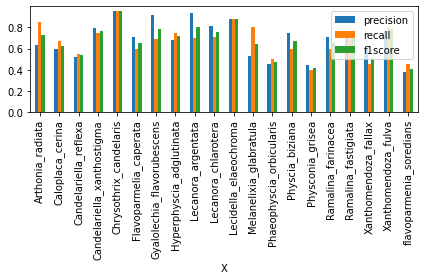

<Figure size 2160x1080 with 0 Axes>

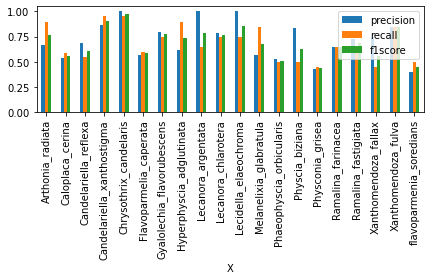

<Figure size 2160x1080 with 0 Axes>

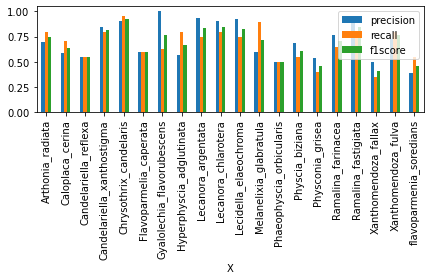

<Figure size 2160x1080 with 0 Axes>

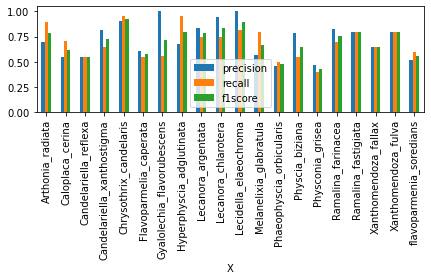

<Figure size 2160x1080 with 0 Axes>

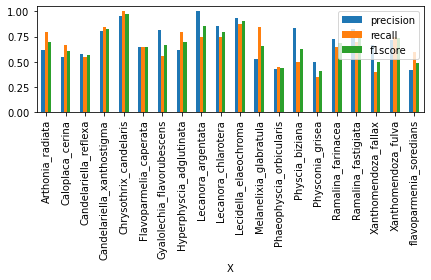

In [8]:
precision = []
recall = []
accuracy = []
visual = ['400','450','500','550','600']


for i,vs in enumerate(visual):
    print('------> ',vs)
    trf = '../../../features_for_python/densesift_' + vs +'_4/training_features.mat'
    trlab = '../../../features_for_python/densesift_' + vs +'_4/training_lab_features.mat'

    tstf = '../../../features_for_python/densesift_' + vs +'_4/testing_features.mat'
    tstlab = '../../../features_for_python/densesift_' + vs +'_4/testing_lab_features.mat'


    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1

    #knnacc, knnprec, knnrec ,_ = train_model_and_calculate_accuracy(training_feat,tr_lab,tst_features,tst_lab)
    
    
    #classifier = KNeighborsClassifier(n_neighbors=1) 
    #classifier.fit(training_feat,tr_lab)
    name = "classic_sift"+str(vs)
    direc = "results/classic_sift/confusion_matrix/"
    #pred = create_and_save_confusion_matrix(classifier, tst_features, tst_lab, species, vs,'','knn_' + vs + '.jpg')
    
    
    
    #plot_and_save_knn(knnacc, knnprec, knnrec,'classic_sift_knn_' + vs + '.jpg')
    
    svm, score = search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    accuracy.append(score)

    pred = create_and_save_confusion_matrix(svm, tst_features, tst_lab, species, vs,direc,name)
    
    a,b,c = calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'prova' + vs +'_')
    precision.append(a)
    recall.append(b)